In [1]:
# !pip install speechbrain==1.0.0
# !pip install torch torchaudio

In [2]:
# !pip install librosa 

In [3]:
from pathlib import Path 
import glob
from tqdm import tqdm
import IPython.display as display
from IPython.display import Audio
import pandas as pd, numpy as np, matplotlib.pyplot as plt

import torchaudio
import librosa
import librosa.display

# Inspect training data 

In [4]:
cats = ["dehumidifier", "gas_boiler", "lesker_system"]
files = []
for cls in cats:
    files += glob.glob(f"../data/{cls}/*.wav")

In [5]:
len(files)

44

In [6]:
files[:3]

['../data/dehumidifier/1000060-11-0-0.wav',
 '../data/dehumidifier/1000024-11-0-0.wav',
 '../data/dehumidifier/1000485-11-0-0.wav']

In [7]:
df = pd.DataFrame(dict(filepath=files))
df["label"] = df.filepath.apply(lambda x: Path(x).parent.name)
df["duration"] = df.filepath.apply(lambda x: librosa.get_duration(path=x))
df.sample(5)

,filepath,label,duration
22,../data/gas_boiler/3000112-12-0-0.wav,gas_boiler,4.0
24,../data/gas_boiler/3000000-12-0-0.wav,gas_boiler,4.0
8,../data/dehumidifier/1000144-11-0-0.wav,dehumidifier,4.0
9,../data/dehumidifier/1000493-11-0-0.wav,dehumidifier,4.0
1,../data/dehumidifier/1000024-11-0-0.wav,dehumidifier,4.0


In [8]:
df.duration.value_counts()

duration
4.0    44
Name: count, dtype: int64

In [9]:
sample = df.sample().iloc[0]; sample

filepath    ../data/gas_boiler/3000004-12-0-0.wav
label                                  gas_boiler
duration                                      4.0
Name: 21, dtype: object

In [10]:
display.Audio(sample.filepath, autoplay=True)

In [11]:
df.label.value_counts()

label
dehumidifier     19
lesker_system    15
gas_boiler       10
Name: count, dtype: int64

In [12]:
def get_sample_of(cls: str, random_state=None):
    return df[df.label == cls].sample(random_state=random_state).iloc[0]
    
def play_sample(sample):
    print(sample.filepath, sample.label)
    return display.Audio(sample.filepath, autoplay=True)

def play_sample_of(cls: str, random_state=None):
    sample = get_sample_of(cls, random_state)
    return play_sample(sample)

In [13]:
def plot_spectrogram(filepath):
    y, sr = librosa.load(filepath)
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_dB = librosa.power_to_db(S, ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-frequency spectrogram')
    plt.tight_layout()
    plt.show()

def show_sample(sample):
    plot_spectrogram(sample.filepath)

def show_sample_of(cls: str, random_state=None):
    sample = get_sample_of(cls, random_state)
    return show_sample(sample)

In [14]:
samp = get_sample_of("dehumidifier")
play_sample(samp)

../data/dehumidifier/1000084-11-0-0.wav dehumidifier


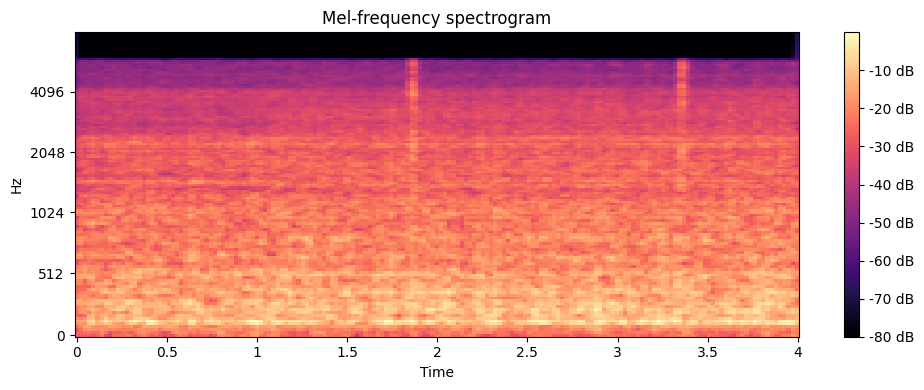

In [15]:
show_sample(samp)

In [16]:
samp = get_sample_of("lesker_system")
play_sample(samp)

../data/lesker_system/2000420-10-0-0.wav lesker_system


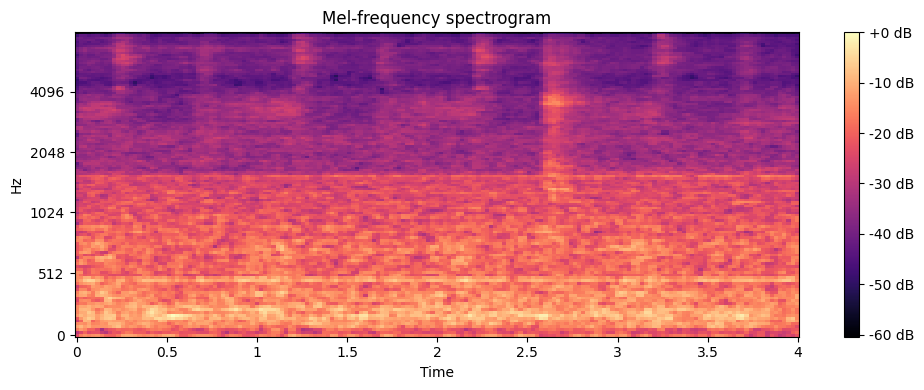

In [17]:
show_sample(samp)

In [18]:
samp = get_sample_of("gas_boiler")
play_sample(samp)

../data/gas_boiler/3000060-12-0-0.wav gas_boiler


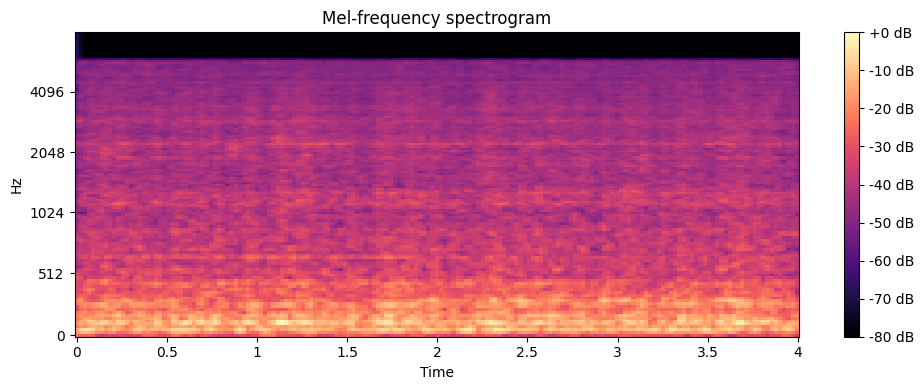

In [19]:
show_sample(samp)

## Train/val split

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
train, val = train_test_split(df, stratify=df.label, random_state=0, test_size=0.17)
train.shape, val.shape

((36, 3), (8, 3))

In [22]:
df['isval'] = [i in val.index for i in df.index]

In [23]:
df[df.isval]

,filepath,label,duration,isval
0,../data/dehumidifier/1000060-11-0-0.wav,dehumidifier,4.0,True
12,../data/dehumidifier/1000084-11-0-0.wav,dehumidifier,4.0,True
15,../data/dehumidifier/1000012-11-0-0.wav,dehumidifier,4.0,True
25,../data/gas_boiler/3000084-12-0-0.wav,gas_boiler,4.0,True
26,../data/gas_boiler/3000144-12-0-0.wav,gas_boiler,4.0,True
33,../data/lesker_system/2000112-10-0-0.wav,lesker_system,4.0,True
37,../data/lesker_system/2000312-10-0-0.wav,lesker_system,4.0,True
38,../data/lesker_system/2000084-10-0-0.wav,lesker_system,4.0,True


In [24]:
train.label.value_counts()

label
dehumidifier     16
lesker_system    12
gas_boiler        8
Name: count, dtype: int64

In [25]:
val.label.value_counts()

label
dehumidifier     3
lesker_system    3
gas_boiler       2
Name: count, dtype: int64

## Speechbrain urbansound model 

In [28]:
import torchaudio
from speechbrain.inference.classifiers import EncoderClassifier
classifier = EncoderClassifier.from_hparams(source="speechbrain/urbansound8k_ecapa", savedir="models/gurbansound8k_ecapa")
out_prob, score, index, text_lab = classifier.classify_file('speechbrain/urbansound8k_ecapa/dog_bark.wav')
print(text_lab)

['dog_bark']


For fun, I'm just going to run the classifier which is predicting urban sounds, and see what it says on random samples from our new dataset - it's interesting what it predicts! 

In [29]:
sample = get_sample_of("lesker_system")
classifier.classify_file(sample.filepath)

(tensor([[-0.4958,  0.0066,  0.4575, -0.2232, -0.0046, -0.2790,  0.3297,  0.3517,
           0.1165,  0.1815]]),
 tensor([0.4575]),
 tensor([2]),
 ['air_conditioner'])

In [30]:
play_sample(sample)

../data/lesker_system/2000220-10-0-0.wav lesker_system


In [37]:
sample = get_sample_of("dehumidifier", random_state=1)
classifier.classify_file(sample.filepath)

(tensor([[-0.6137,  0.2272,  0.2210, -0.0820,  0.2598,  0.0804, -0.1296, -0.0834,
           0.4030, -0.3970]]),
 tensor([0.4030]),
 tensor([8]),
 ['drilling'])

In [38]:
play_sample(sample)

../data/dehumidifier/1000480-11-0-0.wav dehumidifier


## From audio file to tensor to model 

In [39]:
import torchaudio
import torch

different samples have different length tensor (longer or shorter time series) 

In [40]:
sample = get_sample_of("dehumidifier")
tens, size = torchaudio.load(sample.filepath)
tens.shape, size

(torch.Size([1, 64000]), 16000)

the classifier's `load_audio` function does some extra stuff like normalization, so let's use that 


In [41]:
tens = classifier.load_audio(sample.filepath)
tens.shape

torch.Size([64000])

In [42]:
tens.unsqueeze(0).shape

torch.Size([1, 64000])

In [43]:
rel_length =  torch.tensor([1.])
enc = classifier.encode_batch(tens.unsqueeze(0), rel_length)
enc.shape

torch.Size([1, 1, 192])

In [44]:
# probabilities of each class
preds = classifier.mods.classifier(enc).squeeze(1); preds

tensor([[-0.3186, -0.3041,  0.5321, -0.3033,  0.0124, -0.1843,  0.2966,  0.4101,
          0.2640, -0.1770]])

In [45]:
# batch of preds, but just 1 in the batch 
preds.shape

torch.Size([1, 10])

In [46]:
# check that our work agrees with the full implementation 
classifier.classify_file(sample.filepath)

(tensor([[-0.3186, -0.3041,  0.5321, -0.3033,  0.0124, -0.1843,  0.2966,  0.4101,
           0.2640, -0.1770]]),
 tensor([0.5321]),
 tensor([2]),
 ['air_conditioner'])

## Create dataset 

In [47]:
from torch.utils.data import Dataset

In [48]:
cats

['dehumidifier', 'gas_boiler', 'lesker_system']

In [49]:
train.head()

,filepath,label,duration
21,../data/gas_boiler/3000004-12-0-0.wav,gas_boiler,4.0
42,../data/lesker_system/2000060-10-0-0.wav,lesker_system,4.0
40,../data/lesker_system/2000420-10-0-0.wav,lesker_system,4.0
28,../data/gas_boiler/3000024-12-0-0.wav,gas_boiler,4.0
34,../data/lesker_system/2000220-10-0-0.wav,lesker_system,4.0


In [50]:
val.head()

,filepath,label,duration
25,../data/gas_boiler/3000084-12-0-0.wav,gas_boiler,4.0
15,../data/dehumidifier/1000012-11-0-0.wav,dehumidifier,4.0
33,../data/lesker_system/2000112-10-0-0.wav,lesker_system,4.0
0,../data/dehumidifier/1000060-11-0-0.wav,dehumidifier,4.0
37,../data/lesker_system/2000312-10-0-0.wav,lesker_system,4.0


In [51]:
from functools import cache

class ApplianceDS(Dataset):
    def __init__(self, df):
        self.df = df
    def __len__(self): return len(df)
    
    @cache
    def __getitem__(self, i):
        item = df.iloc[i]
        X = classifier.load_audio(item.filepath)
        # X = classifier.encode_batch(X).squeeze(1)
        y = torch.zeros(3)
        y[cats.index(item.label)] = 1.
        return X, y

In [52]:
tensors = [classifier.load_audio(fp) for fp in df.filepath]

In [55]:
shapes = df.filepath.apply(lambda x: classifier.load_audio(x).shape)

In [57]:
shapes.value_counts()

filepath
(64000,)    44
Name: count, dtype: int64

In [58]:
train_ds = ApplianceDS(train)
val_ds = ApplianceDS(val)

In [59]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=8, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=8, shuffle=True)

In [64]:
for X, y in val_dl:
    print(X.shape, y.shape, y)
    break

torch.Size([8, 64000]) torch.Size([8, 3]) tensor([[0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])


In [65]:
logits, confidences, classes, decoded_classes = classifier(X)

In [66]:
logits

tensor([[-0.5332, -0.2324,  0.3373,  0.0470, -0.0457, -0.1076,  0.0014,  0.2434,
          0.7089,  0.0295],
        [-0.3539, -0.2416,  0.6259, -0.2306,  0.0115, -0.1471,  0.2575,  0.3100,
          0.3123, -0.2169],
        [-0.3289, -0.2630,  0.6697, -0.3248,  0.0683, -0.1365,  0.2417,  0.2942,
          0.0907, -0.1382],
        [-0.4610, -0.2314,  0.1725, -0.0974,  0.0652, -0.1580,  0.3313,  0.6189,
          0.3548, -0.0940],
        [-0.3975, -0.0691,  0.3702, -0.3156, -0.0449, -0.0447,  0.3708,  0.3850,
          0.3049, -0.0600],
        [-0.2540, -0.2785,  0.3810, -0.3076, -0.0314, -0.3169,  0.4255,  0.4879,
          0.2340, -0.0847],
        [-0.3969, -0.3374,  0.2403, -0.0861,  0.0763, -0.2435,  0.3896,  0.6019,
          0.2596, -0.0445],
        [-0.2519, -0.1324,  0.3397, -0.3774,  0.0173, -0.2476,  0.3164,  0.4840,
          0.3121, -0.0147]])

In [67]:
confidences

tensor([0.7089, 0.6259, 0.6697, 0.6189, 0.3850, 0.4879, 0.6019, 0.4840])

In [68]:
decoded_classes

['drilling',
 'air_conditioner',
 'air_conditioner',
 'jackhammer',
 'jackhammer',
 'jackhammer',
 'jackhammer',
 'jackhammer']

In [69]:
len(val_dl)

6

In [73]:
# torch.nn.init.xavier_uniform_??

In [70]:
def reset_weights():
    classifier.mods.classifier.weight = torch.nn.Parameter(torch.FloatTensor(3, 192))
    torch.nn.init.xavier_uniform_(classifier.mods.classifier.weight)
reset_weights()

In [71]:
for param in classifier.mods.classifier.parameters():
    print(param.requires_grad)

True


In [77]:
for mod in classifier.mods:
    print(mod)
    # for p in classifier.__getattr__(mod).parameters():
    #     print(mod, p.requires_grad)

compute_features
mean_var_norm
embedding_model
classifier


In [ ]:
torch.functional.cross

In [84]:
loss_fn = torch.nn.CrossEntropyLoss()
loss_fn = torch.nn.functional.binary_cross_entropy_with_logits

In [85]:
y

tensor([[0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])

In [87]:
logits

tensor([[-0.5332, -0.2324,  0.3373,  0.0470, -0.0457, -0.1076,  0.0014,  0.2434,
          0.7089,  0.0295],
        [-0.3539, -0.2416,  0.6259, -0.2306,  0.0115, -0.1471,  0.2575,  0.3100,
          0.3123, -0.2169],
        [-0.3289, -0.2630,  0.6697, -0.3248,  0.0683, -0.1365,  0.2417,  0.2942,
          0.0907, -0.1382],
        [-0.4610, -0.2314,  0.1725, -0.0974,  0.0652, -0.1580,  0.3313,  0.6189,
          0.3548, -0.0940],
        [-0.3975, -0.0691,  0.3702, -0.3156, -0.0449, -0.0447,  0.3708,  0.3850,
          0.3049, -0.0600],
        [-0.2540, -0.2785,  0.3810, -0.3076, -0.0314, -0.3169,  0.4255,  0.4879,
          0.2340, -0.0847],
        [-0.3969, -0.3374,  0.2403, -0.0861,  0.0763, -0.2435,  0.3896,  0.6019,
          0.2596, -0.0445],
        [-0.2519, -0.1324,  0.3397, -0.3774,  0.0173, -0.2476,  0.3164,  0.4840,
          0.3121, -0.0147]])

In [88]:
logits, confidences, classes, decoded_classes = classifier(X)
loss_fn(logits,y)

tensor(0.7027, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [89]:
loss_fn(torch.tensor([-0.000,  1., 0.00]), y[0])

tensor(0.8999)

In [90]:
loss_fn(y,y)

tensor(0.5665)

In [109]:
reset_weights()

In [110]:
for X, y in val_dl:
    print(X.shape, y.shape)

torch.Size([8, 64000]) torch.Size([8, 3])
torch.Size([8, 64000]) torch.Size([8, 3])
torch.Size([8, 64000]) torch.Size([8, 3])
torch.Size([8, 64000]) torch.Size([8, 3])
torch.Size([8, 64000]) torch.Size([8, 3])
torch.Size([4, 64000]) torch.Size([4, 3])


In [111]:
loss_over_time = []
optimizer = torch.optim.Adam(classifier.mods.classifier.parameters(), lr=0.001)

for epoch in range(10):
    losses = []
    for batch_idx, (X, y) in enumerate(train_dl):
        logits, confidences, classes, decoded_classes = classifier(X)
        loss = loss_fn(logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    epoch_loss = np.mean(losses)
    loss_over_time.append(epoch_loss)
    # if epoch % 10 == 0:
    print(f"{epoch_loss:.4f}")

0.6950
0.6857
0.6794
0.6740
0.6712
0.6641
0.6572
0.6538
0.6486
0.6481


In [102]:
import torch
import torch.nn.functional as F

# Example with one-hot encoded labels
logits = torch.tensor([[1., 0.]])
labels = torch.tensor([[1., 0.]])
loss = F.binary_cross_entropy_with_logits(logits, labels.float())
loss = F.cross_entropy(logits, torch.tensor([0]) )
print(loss)  # Output: 0.0


tensor(0.3133)


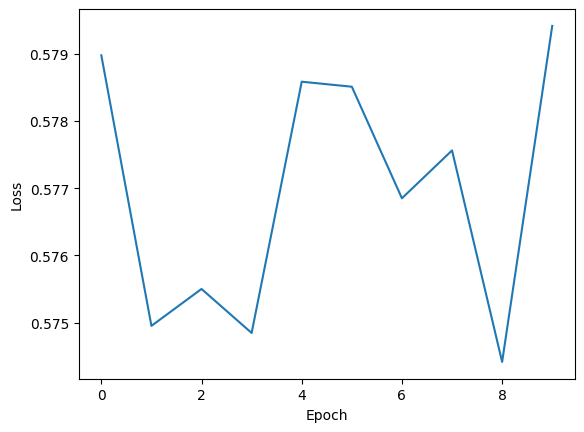

In [103]:
plt.plot(loss_over_time)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [104]:
# Define model, optimizer, loss function, and dataloader
# optimizer = torch.optim.Adam(classifier.mods.classifier.parameters(), lr=0.001)

# for epoch in range(10000):
#     losses = []
#     for batch_idx, (X, y) in enumerate(train_dl):
#         logits, confidences, classes, decoded_classes = classifier(X)
#         # print(ypred, y)
#         loss = loss_fn(logits, y)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         losses.append(loss.item())
#     if epoch % 10 == 0:
#         print(f"{np.mean(losses):.4f}")
        
        # print(f"Epoch {epoch}[{batch_idx}/{len(train_dl)}], Loss: {loss.item():.4f}")

In [105]:
Xval, yval = list(torch.utils.data.DataLoader(val_ds, batch_size=10))[0]

In [106]:
type(classifier)

speechbrain.inference.classifiers.EncoderClassifier

In [108]:
classifier(Xval)

(tensor([[-0.0763, -0.7709, -0.6075],
         [-0.0586, -0.8002, -0.5552],
         [-0.0654, -0.7880, -0.5716],
         [-0.0161, -0.5259, -0.1252],
         [-0.0559, -0.8240, -0.5328],
         [-0.1096, -0.7966, -0.5198],
         [-0.0158, -0.7995, -0.5969],
         [-0.1341, -0.7382, -0.5841],
         [-0.1013, -0.7464, -0.5811],
         [ 0.0163, -0.8242, -0.5547]], grad_fn=<SqueezeBackward1>),
 tensor([-0.0763, -0.0586, -0.0654, -0.0161, -0.0559, -0.1096, -0.0158, -0.1341,
         -0.1013,  0.0163], grad_fn=<MaxBackward0>),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 ['dog_bark',
  'dog_bark',
  'dog_bark',
  'dog_bark',
  'dog_bark',
  'dog_bark',
  'dog_bark',
  'dog_bark',
  'dog_bark',
  'dog_bark'])

In [ ]:
Xval.shape, yval.shape

In [ ]:
yval

In [ ]:
val